In [97]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from math import sqrt

import warnings
warnings.filterwarnings('ignore')

## 1 - Exploración de los datos

In [191]:
data = pd.read_csv('dataset_flujo_vehicular.csv')

In [192]:
data

,CODIGO_LOCACION,HORA,CANTIDAD,SENTIDO,LATITUD,LONGITUD
0,48Q3CJ00+,31MAR2020:15:00:00,729,Interna,-34.588796,-58.381520
1,48Q3CJ00+,31MAR2020:15:00:00,447,Egreso,-34.588796,-58.381520
2,48Q39G00+,31MAR2020:15:00:00,175,Interna,-34.633299,-58.468594
3,48Q39G00+,31MAR2020:15:00:00,1186,Egreso,-34.633299,-58.468594
4,48Q3CH00+,31MAR2020:15:00:00,35,Egreso,-34.579632,-58.427733
...,...,...,...,...,...,...
95920,48Q3CJ00+,26JAN2021:11:00:00,2560,Egreso,-34.588796,-58.381520
95921,48Q3CJ00+,26JAN2021:11:00:00,2951,Ingreso,-34.588796,-58.381520
95922,48Q3CJ00+,26JAN2021:11:00:00,4539,Interna,-34.588796,-58.381520
95923,48Q3CJ00+,26JAN2021:12:00:00,2628,Egreso,-34.588796,-58.381520


In [193]:
# Convertimos la fecha a datetime
data.HORA = pd.to_datetime(arg=data.HORA, format='%d%b%Y:%H:%M:%S')

In [194]:
data.dtypes

CODIGO_LOCACION            object
HORA               datetime64[ns]
CANTIDAD                    int64
SENTIDO                    object
LATITUD                   float64
LONGITUD                  float64
dtype: object

In [195]:
# Creamos una columna de años
data['year'] = [d.year for d in data.HORA]
# Creamos una columna mes
data['month'] = [d.strftime('%b') for d in data.HORA]
# Creamos una columna hora
data['hour'] = [d.strftime('%H') for d in data.HORA]

In [245]:
# 48Q39G00+ == San Pedrito y Av. Juan Bautista Alberdi
data.CODIGO_LOCACION.value_counts()

48Q3CJ00+    26245
48Q39G00+    26054
48Q3CH00+    17367
48Q39H00+     8758
48Q39J00+     8757
48Q3FG00+     8587
2H2M2200+       79
27262200+       78
Name: CODIGO_LOCACION, dtype: int64

In [197]:
data.groupby('CODIGO_LOCACION')['CANTIDAD'].sum().sort_values(ascending=False).head()

CODIGO_LOCACION
48Q39G00+    62020183
48Q3CJ00+    42852763
48Q39J00+    34367352
48Q39H00+    34299678
48Q3CH00+    14807153
Name: CANTIDAD, dtype: int64

In [251]:
data_locacion = data.drop_duplicates(subset='CODIGO_LOCACION', keep='first')
data_locacion.drop(columns=['HORA', 'CANTIDAD', 'SENTIDO', 'year','month','hour'],axis=1, inplace=True)
data_locacion

,CODIGO_LOCACION,LATITUD,LONGITUD
0,48Q3CJ00+,-34.588796,-58.381520
2,48Q39G00+,-34.633299,-58.468594
4,48Q3CH00+,-34.579632,-58.427733
6,48Q39J00+,-34.608550,-58.372951
9,48Q3FG00+,-34.536980,-58.470968
16,48Q39H00+,-34.618036,-58.410236
8351,27262200+,NaN,NaN
8356,2H2M2200+,NaN,NaN


In [252]:
%load_ext autotime 

import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import plotly_express as px
import tqdm
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

time: 453 ms (started: 2021-03-20 20:44:01 -03:00)


In [254]:
px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
px.scatter_mapbox(data_locacion, lat="LATITUD", lon= "LONGITUD", hover_name=data_locacion.CODIGO_LOCACION)

time: 67.1 ms (started: 2021-03-20 20:47:15 -03:00)


In [ ]:
addres = []

for i in range(lon_lat.shape[0]):

    lat = str(lon_lat["Latitud"][i])
    lon = str(lon_lat["Longitud"][i])
    cords = (lat + ", " + lon)
    coordinates = cords
    
    locator = Nominatim(user_agent="myGeocoder")    
    location = locator.reverse(coordinates)
    addres.append(location.address)

In [198]:
data.SENTIDO.unique()

array(['Interna', 'Egreso', 'Ingreso'], dtype=object)

In [199]:
data.LATITUD.unique()

array([-34.588796, -34.633299, -34.579632, -34.60855 , -34.53698 ,
       -34.618036,        nan])

In [200]:
data.LONGITUD.unique()

array([-58.38152 , -58.468594, -58.427733, -58.372951, -58.470968,
       -58.410236,        nan, -58.468594, -58.427733, -58.38152 ])

In [203]:
# Función que plotea la serie:
def plot_df(data, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=100, color='tab:red'):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color=color)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [204]:
# Creamos un primer dataset con un solo sensor
data_v1 = data.loc[data['CODIGO_LOCACION'] == '48Q39G00+']
data_v1.reset_index(drop=True, inplace=True)
data_v1

,CODIGO_LOCACION,HORA,CANTIDAD,SENTIDO,LATITUD,LONGITUD,year,month,hour
0,48Q39G00+,2020-03-31 15:00:00,175,Interna,-34.633299,-58.468594,2020,Mar,15
1,48Q39G00+,2020-03-31 15:00:00,1186,Egreso,-34.633299,-58.468594,2020,Mar,15
2,48Q39G00+,2020-03-31 15:00:00,1235,Ingreso,-34.633299,-58.468594,2020,Mar,15
3,48Q39G00+,2020-03-31 14:00:00,1535,Egreso,-34.633299,-58.468594,2020,Mar,14
4,48Q39G00+,2020-03-31 14:00:00,155,Interna,-34.633299,-58.468594,2020,Mar,14
...,...,...,...,...,...,...,...,...,...
26049,48Q39G00+,2021-02-10 19:00:00,3784,Ingreso,-34.633299,-58.468594,2021,Feb,19
26050,48Q39G00+,2021-02-10 19:00:00,1017,Interna,-34.633299,-58.468594,2021,Feb,19
26051,48Q39G00+,2021-02-10 20:00:00,4533,Egreso,-34.633299,-58.468594,2021,Feb,20
26052,48Q39G00+,2021-02-10 20:00:00,3606,Ingreso,-34.633299,-58.468594,2021,Feb,20


In [205]:
data_v2 = data_v1.loc[data_v1['CANTIDAD'] < 25000]
data_v2 = data_v1.loc[data_v1['SENTIDO'] == 'Egreso']
data_v2.reset_index(drop=True, inplace=True)
data_v2.drop(labels=['CODIGO_LOCACION', 'SENTIDO', 'LATITUD','LONGITUD'], axis=1, inplace=True)

In [206]:
data_v2.sort_values(by=['HORA'], ascending=True, inplace=True)
data_v2.reset_index(drop=True, inplace=True)

In [207]:
data_v2

,HORA,CANTIDAD,year,month,hour
0,2020-03-02 00:00:00,3421,2020,Mar,00
1,2020-03-02 01:00:00,2036,2020,Mar,01
2,2020-03-02 02:00:00,1303,2020,Mar,02
3,2020-03-02 03:00:00,1089,2020,Mar,03
4,2020-03-02 04:00:00,1519,2020,Mar,04
...,...,...,...,...,...
8739,2021-03-01 17:00:00,7822,2021,Mar,17
8740,2021-03-01 18:00:00,8118,2021,Mar,18
8741,2021-03-01 19:00:00,5604,2021,Mar,19
8742,2021-03-01 20:00:00,4801,2021,Mar,20


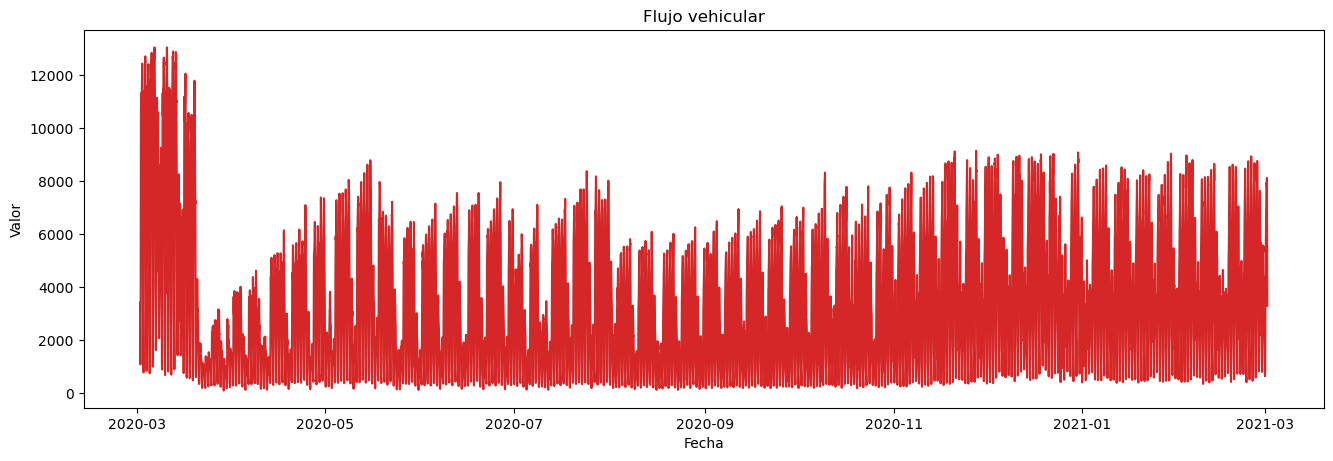

In [208]:
plot_df(data_v2, x=data_v2.HORA, y=data_v2.CANTIDAD,\
        title='Flujo vehicular')

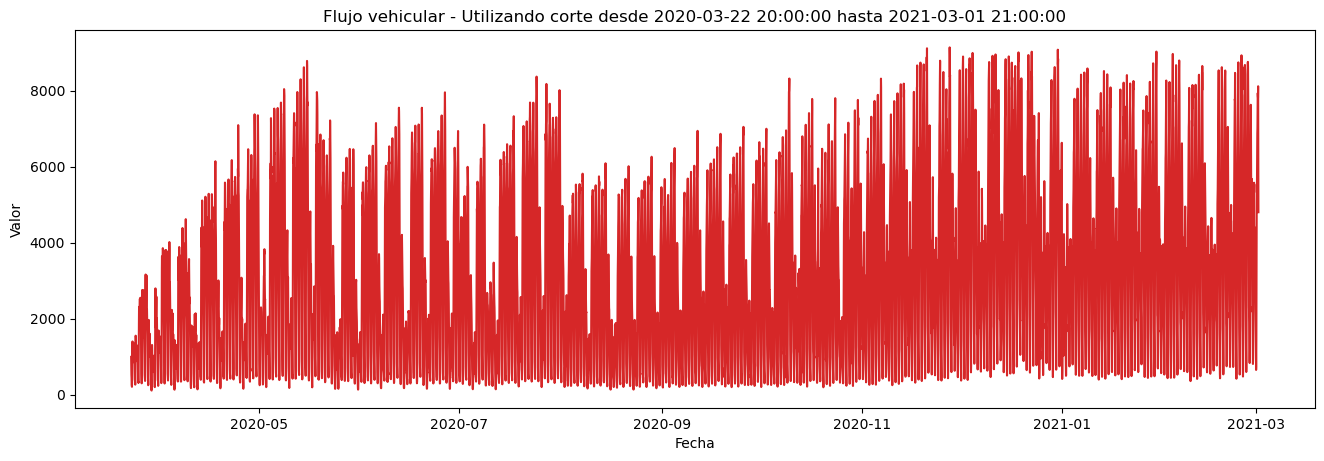

In [209]:
desde = '2020-03-22 20:00:00'
hasta = '2021-03-01 21:00:00'
corte_mask = (data_v2['HORA'] > desde)  & (data_v2['HORA'] < hasta)
plot_df(data_v2[corte_mask], x=data_v2.HORA[corte_mask], y=data_v2.CANTIDAD[corte_mask],\
        title='Flujo vehicular - Utilizando corte desde %s hasta %s' % (desde, hasta)) 

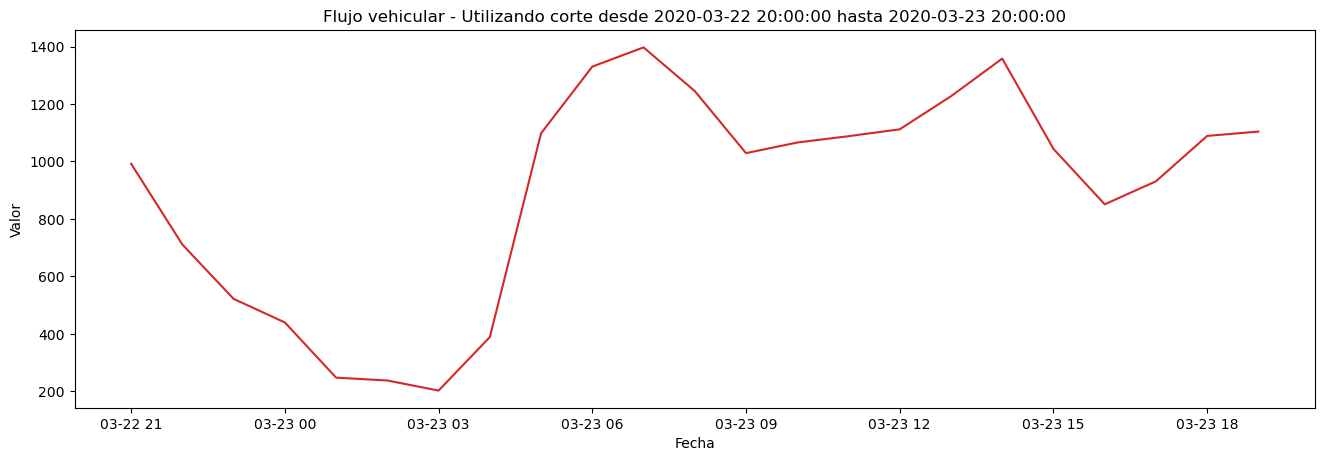

In [210]:
desde = '2020-03-22 20:00:00'
hasta = '2020-03-23 20:00:00'
corte_mask = (data_v2['HORA'] > desde)  & (data_v2['HORA'] < hasta)
plot_df(data_v2[corte_mask], x=data_v2.HORA[corte_mask], y=data_v2.CANTIDAD[corte_mask],\
        title='Flujo vehicular - Utilizando corte desde %s hasta %s' % (desde, hasta), xlabel='Fecha') 

## 2 - Seleccionamos el rango de datos a estudiar

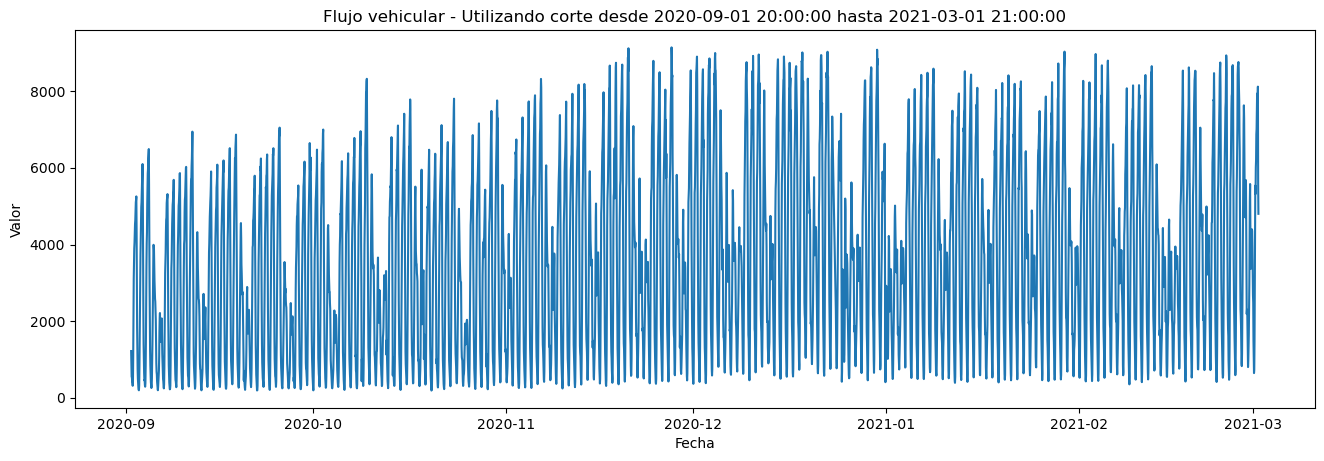

In [212]:
desde = '2020-09-01 20:00:00'
hasta = '2021-03-01 21:00:00'
corte_mask = (data_v2['HORA'] > desde)  & (data_v2['HORA'] < hasta)

plot_df(data_v2[corte_mask], x=data_v2.HORA[corte_mask], y=data_v2.CANTIDAD[corte_mask], color='tab:blue',\
        title='Flujo vehicular - Utilizando corte desde %s hasta %s' % (desde, hasta)) 

data_v2 = data_v2[corte_mask]


In [213]:
data_v2

,HORA,CANTIDAD,year,month,hour
4413,2020-09-01 21:00:00,1222,2020,Sep,21
4414,2020-09-01 22:00:00,837,2020,Sep,22
4415,2020-09-01 23:00:00,552,2020,Sep,23
4416,2020-09-02 00:00:00,529,2020,Sep,00
4417,2020-09-02 01:00:00,416,2020,Sep,01
...,...,...,...,...,...
8738,2021-03-01 16:00:00,7844,2021,Mar,16
8739,2021-03-01 17:00:00,7822,2021,Mar,17
8740,2021-03-01 18:00:00,8118,2021,Mar,18
8741,2021-03-01 19:00:00,5604,2021,Mar,19


In [214]:
data_v2["timeIndex"] = pd.Series(np.arange(len(data_v2['CANTIDAD'])), index=data_v2.index)

data_v2.head()

# Comentario: recordá que la dummy de tiempo es una variable de apoyo que lleva la cuenta de
# la cantidad de periodos que pasan desde la primera observación. Sirve para poder hacer
# regresiones contra el tiempo y estimar la tendencia. 

,HORA,CANTIDAD,year,month,hour,timeIndex
4413,2020-09-01 21:00:00,1222,2020,Sep,21,0
4414,2020-09-01 22:00:00,837,2020,Sep,22,1
4415,2020-09-01 23:00:00,552,2020,Sep,23,2
4416,2020-09-02 00:00:00,529,2020,Sep,00,3
4417,2020-09-02 01:00:00,416,2020,Sep,01,4


In [215]:
data_v2.tail()

,HORA,CANTIDAD,year,month,hour,timeIndex
8738,2021-03-01 16:00:00,7844,2021,Mar,16,4325
8739,2021-03-01 17:00:00,7822,2021,Mar,17,4326
8740,2021-03-01 18:00:00,8118,2021,Mar,18,4327
8741,2021-03-01 19:00:00,5604,2021,Mar,19,4328
8742,2021-03-01 20:00:00,4801,2021,Mar,20,4329


In [216]:
dummies_hora = pd.get_dummies(data_v2['hour'], drop_first=True, prefix='h')
data_v2 =  data_v2.join(dummies_hora)
data_v2.sample(10)

,HORA,CANTIDAD,year,month,hour,timeIndex,h_01,h_02,h_03,h_04,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
8597,2021-02-23 19:00:00,5961,2021,Feb,19,4184,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7502,2021-01-09 04:00:00,596,2021,Jan,04,3089,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6679,2020-12-05 08:00:00,4323,2020,Dec,08,2266,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8724,2021-03-01 02:00:00,965,2021,Mar,02,4311,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8333,2021-02-12 19:00:00,6596,2021,Feb,19,3920,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8665,2021-02-26 15:00:00,8760,2021,Feb,15,4252,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8370,2021-02-14 08:00:00,1629,2021,Feb,08,3957,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7553,2021-01-11 07:00:00,4010,2021,Jan,07,3140,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4875,2020-09-21 03:00:00,281,2020,Sep,03,462,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6115,2020-11-11 19:00:00,4616,2020,Nov,19,1702,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [217]:
data_train, data_test = train_test_split(data_v2, test_size=120, random_state=42, shuffle=False)

In [218]:
display(data_train)
display(data_test)

,HORA,CANTIDAD,year,month,hour,timeIndex,h_01,h_02,h_03,h_04,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
4413,2020-09-01 21:00:00,1222,2020,Sep,21,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4414,2020-09-01 22:00:00,837,2020,Sep,22,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4415,2020-09-01 23:00:00,552,2020,Sep,23,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4416,2020-09-02 00:00:00,529,2020,Sep,00,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4417,2020-09-02 01:00:00,416,2020,Sep,01,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8618,2021-02-24 16:00:00,8933,2021,Feb,16,4205,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8619,2021-02-24 17:00:00,8768,2021,Feb,17,4206,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8620,2021-02-24 18:00:00,8439,2021,Feb,18,4207,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8621,2021-02-24 19:00:00,5901,2021,Feb,19,4208,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


,HORA,CANTIDAD,year,month,hour,timeIndex,h_01,h_02,h_03,h_04,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
8623,2021-02-24 21:00:00,3521,2021,Feb,21,4210,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8624,2021-02-24 22:00:00,2214,2021,Feb,22,4211,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8625,2021-02-24 23:00:00,1801,2021,Feb,23,4212,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8626,2021-02-25 00:00:00,1616,2021,Feb,00,4213,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8627,2021-02-25 01:00:00,963,2021,Feb,01,4214,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8738,2021-03-01 16:00:00,7844,2021,Mar,16,4325,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8739,2021-03-01 17:00:00,7822,2021,Mar,17,4326,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8740,2021-03-01 18:00:00,8118,2021,Mar,18,4327,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8741,2021-03-01 19:00:00,5604,2021,Mar,19,4328,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [219]:
# Transformamos los datos
data_train['log_value'] = np.log(data_train['CANTIDAD'])
data_test['log_value'] = np.log(data['CANTIDAD'])

In [220]:
# Probar los datos elevandolos al cubo

data_train['x3_value'] = data_train.CANTIDAD.apply(lambda x: x**3)
data_test['x3_value'] = data_test.CANTIDAD.apply(lambda x: x**3)

In [221]:
data_train

,HORA,CANTIDAD,year,month,hour,timeIndex,h_01,h_02,h_03,h_04,...,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23,log_value,x3_value
4413,2020-09-01 21:00:00,1222,2020,Sep,21,0,0,0,0,0,...,0,0,0,0,0,1,0,0,7.108244,1824793048
4414,2020-09-01 22:00:00,837,2020,Sep,22,1,0,0,0,0,...,0,0,0,0,0,0,1,0,6.729824,586376253
4415,2020-09-01 23:00:00,552,2020,Sep,23,2,0,0,0,0,...,0,0,0,0,0,0,0,1,6.313548,168196608
4416,2020-09-02 00:00:00,529,2020,Sep,00,3,0,0,0,0,...,0,0,0,0,0,0,0,0,6.270988,148035889
4417,2020-09-02 01:00:00,416,2020,Sep,01,4,1,0,0,0,...,0,0,0,0,0,0,0,0,6.030685,71991296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8618,2021-02-24 16:00:00,8933,2021,Feb,16,4205,0,0,0,0,...,1,0,0,0,0,0,0,0,9.097508,712839902237
8619,2021-02-24 17:00:00,8768,2021,Feb,17,4206,0,0,0,0,...,0,1,0,0,0,0,0,0,9.078864,674064760832
8620,2021-02-24 18:00:00,8439,2021,Feb,18,4207,0,0,0,0,...,0,0,1,0,0,0,0,0,9.040619,600997908519
8621,2021-02-24 19:00:00,5901,2021,Feb,19,4208,0,0,0,0,...,0,0,0,1,0,0,0,0,8.682877,205483447701


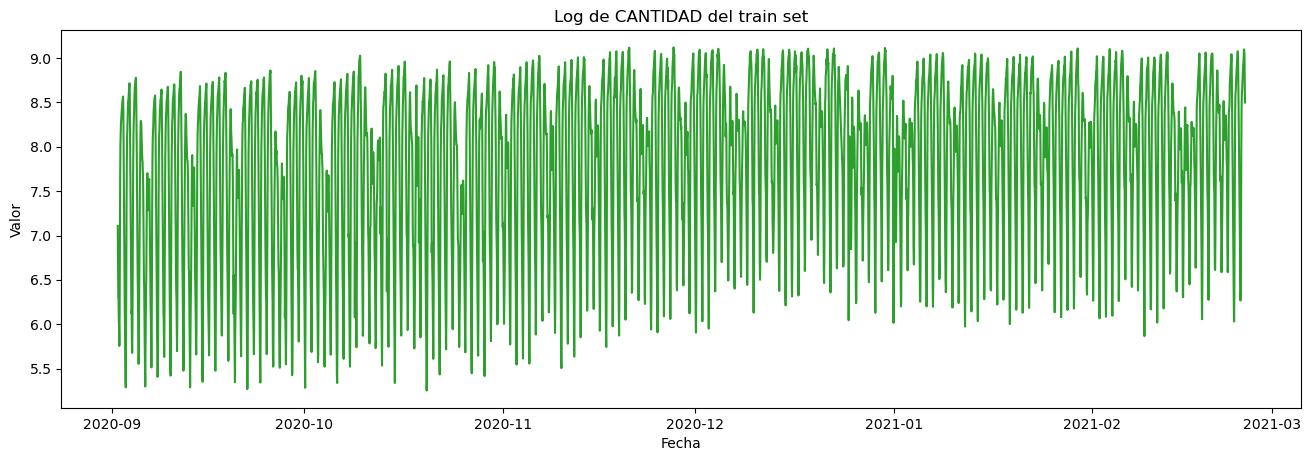

In [222]:
plot_df(data_train, x=data_train.HORA, y=data_train['log_value'],color='tab:green',\
    title='Log de CANTIDAD del train set')

In [223]:
model_log = smf.ols('log_value ~ timeIndex', data = data_train).fit()

In [224]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     227.9
Date:                Sat, 20 Mar 2021   Prob (F-statistic):           3.51e-50
Time:                        20:30:09   Log-Likelihood:                -5627.4
No. Observations:                4210   AIC:                         1.126e+04
Df Residuals:                    4208   BIC:                         1.127e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4401      0.028    262.057      0.000       7.384       7.496
timeIndex      0.0002   1.17e-05     15.095      0.000       0.000       0.000
==============================================================================
Omnibus:                      548.830   Durbin-Watson:                   0.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.132
Skew:                          -0.571   Prob(JB):                     1.38e-74
Kurtosis:                       2.203   Cond. No.                     4.86e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [225]:
# Obtenemos las predicciones  del modelo
data_train['model_log'] = model_log.predict(data_train[["timeIndex"]])
data_test['model_log'] = model_log.predict(data_test[["timeIndex"]])

In [226]:
# Volvemos a 'transformar' los datos exponencialmente
data_train['back_model_log'] = np.exp(data_train['model_log'])
data_test['back_model_log'] = np.exp(data_test['model_log'])

<AxesSubplot:xlabel='HORA'>

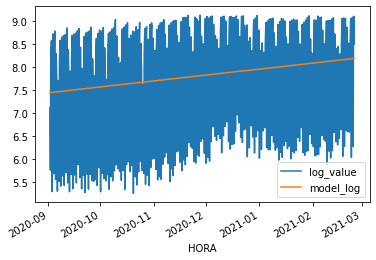

In [227]:
# Ploteamos los datos transformados y la predccion
data_train.plot(kind = "line", x = "HORA", y = ['log_value', 'model_log'])

<AxesSubplot:xlabel='HORA'>

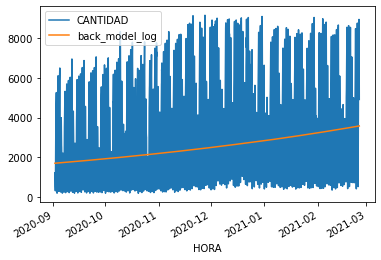

In [228]:
# Ploteamos los datos originales y la prediccion
data_train.plot(kind = "line", x = "HORA", y = ['CANTIDAD', 'back_model_log'])

<AxesSubplot:xlabel='HORA'>

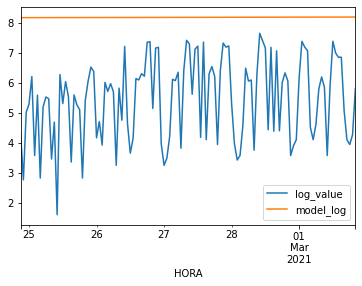

In [229]:
data_test.plot(kind = "line", x = "HORA", y = ['log_value', 'model_log'])

<AxesSubplot:xlabel='HORA'>

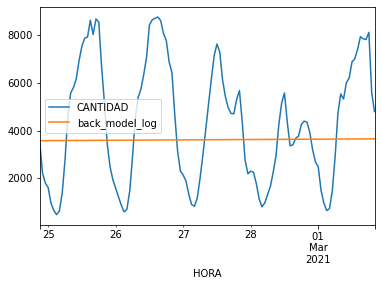

In [230]:
data_test.plot(kind = "line", x = "HORA", y = ['CANTIDAD', 'back_model_log'])

In [231]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [233]:
data_Results = pd.DataFrame(columns = ["Model", "RMSE"])
data_Results.loc[0, "Model"] = "Log"
data_Results.loc[0, "RMSE"] = RMSE(data_test.back_model_log, data_test.CANTIDAD)
data_Results

,Model,RMSE
0,Log,2618.5


In [234]:
# Agregamos estacionalidad por hora
model_log_est = smf.ols('log_value ~ timeIndex + h_01 + h_02 + h_03 + h_04 + h_05 + h_06 + h_07 + h_08 + h_09 + h_10 + h_11 + h_12 + h_13 + h_14 + h_15 + h_16 + h_17 + h_18 + h_19 + h_20 + h_21 + h_22 + h_23',  data = data_train).fit()


In [235]:
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     1037.
Date:                Sat, 20 Mar 2021   Prob (F-statistic):               0.00
Time:                        20:30:36   Log-Likelihood:                -1658.8
No. Observations:                4210   AIC:                             3368.
Df Residuals:                    4185   BIC:                             3526.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6269      0.029    230.360      0.000       6.571       6.683
timeIndex      0.0002   4.56e-06     38.128      0.000       0.000       0.000
h_01          -0.2622      0.038     -6.835      0.000      -0.337      -0.187
h_02          -0.6656      0.038    -17.348      0.000      -0.741      -0.590
h_03          -0.9255      0.038    -24.124      0.000      -1.001      -0.850
h_04          -0.7411      0.038    -19.317      0.000      -0.816      -0.666
h_05          -0.0604      0.038     -1.575      0.115      -0.136       0.015
h_06           0.5224      0.038     13.617      0.000       0.447       0.598
h_07           0.9535      0.038     24.855      0.000       0.878       1.029
h_08           1.1474      0.038     29.909      0.000       1.072       1.223
h_09           1.3058      0.038     34.037      0.000       1.231       1.381
h_10           1.4526      0.038     37.863      0.000       1.377       1.528
h_11           1.5919      0.038     41.434      0.000       1.517       1.667
h_12           1.6588      0.038     43.176      0.000       1.583       1.734
h_13           1.6204      0.038     42.178      0.000       1.545       1.696
h_14           1.5976      0.038     41.583      0.000       1.522       1.673
h_15           1.6056      0.038     41.791      0.000       1.530       1.681
h_16           1.6232      0.038     42.251      0.000       1.548       1.699
h_17           1.6484      0.038     42.904      0.000       1.573       1.724
h_18           1.5747      0.038     40.988      0.000       1.499       1.650
h_19           1.3816      0.038     35.961      0.000       1.306       1.457
h_20           1.1895      0.038     30.962      0.000       1.114       1.265
h_21           0.8364      0.038     21.771      0.000       0.761       0.912
h_22           0.4568      0.038     11.891      0.000       0.382       0.532
h_23           0.1547      0.038      4.021      0.000       0.079       0.230
==============================================================================
Omnibus:                      417.251   Durbin-Watson:                   0.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              592.585
Skew:                          -0.775   Prob(JB):                    2.10e-129
Kurtosis:                       3.986   Cond. No.                     5.94e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [236]:
# Calculamos las predicciones
data_train['model_log_est'] = model_log_est.predict(data_train[["timeIndex",\
                                              'h_01', 'h_02', 'h_03', 'h_04', 'h_05', 'h_06',\
                                                  'h_07', 'h_08', 'h_09', 'h_10', 'h_11',  'h_12',\
                                                      'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18',\
                                                          'h_19', 'h_20', 'h_21', 'h_22', 'h_23']])


data_test['model_log_est'] = model_log_est.predict(data_test[["timeIndex",\
                                              'h_01', 'h_02', 'h_03', 'h_04', 'h_05', 'h_06',\
                                                  'h_07', 'h_08', 'h_09', 'h_10', 'h_11',  'h_12',\
                                                      'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18',\
                                                          'h_19', 'h_20', 'h_21', 'h_22', 'h_23']])

In [237]:
data_train['back_model_log_est'] = np.exp(data_train['model_log_est'])
data_test['back_model_log_est'] = np.exp(data_test['model_log_est'])

<AxesSubplot:xlabel='HORA'>

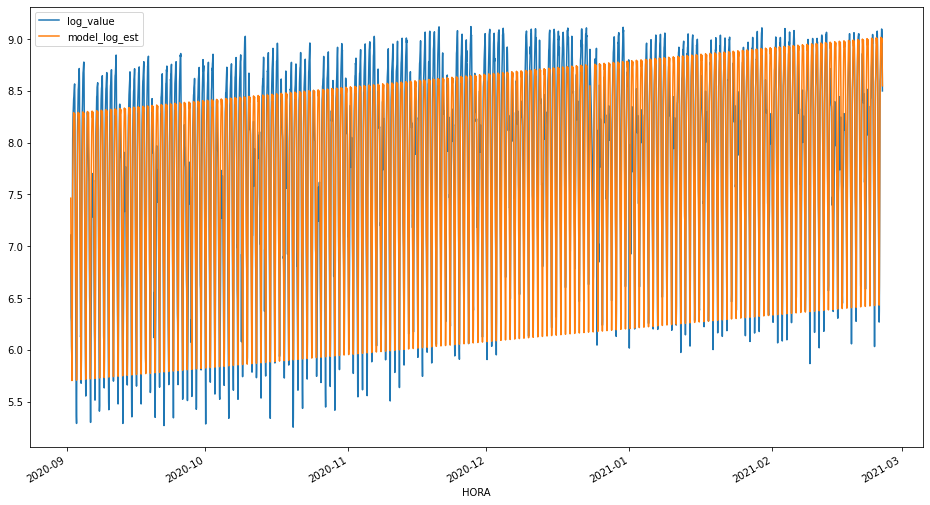

In [238]:
data_train.plot(kind = "line", x = "HORA", y = ['log_value', 'model_log_est'], figsize=(16,9))

<AxesSubplot:xlabel='HORA'>

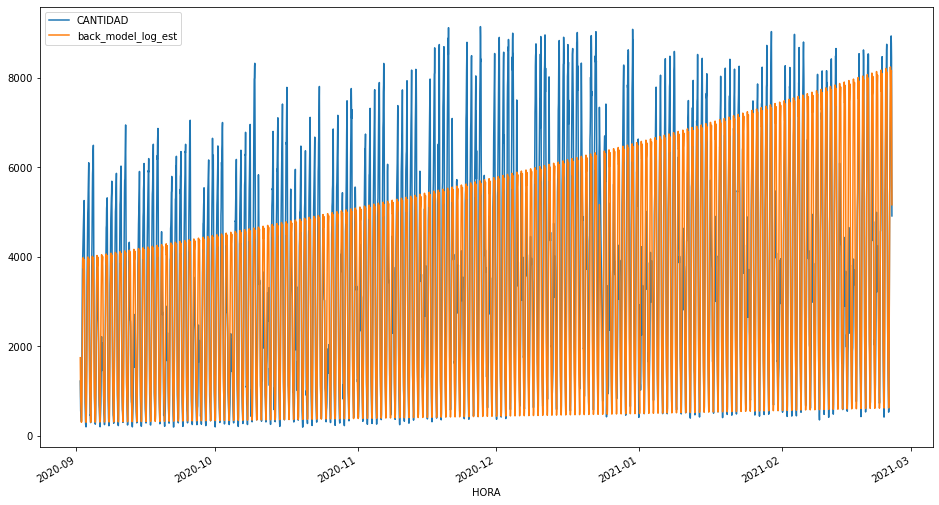

In [239]:
data_train.plot(kind = "line", x = "HORA", y = ['CANTIDAD', 'back_model_log_est'], figsize=(16,9))

<AxesSubplot:xlabel='HORA'>

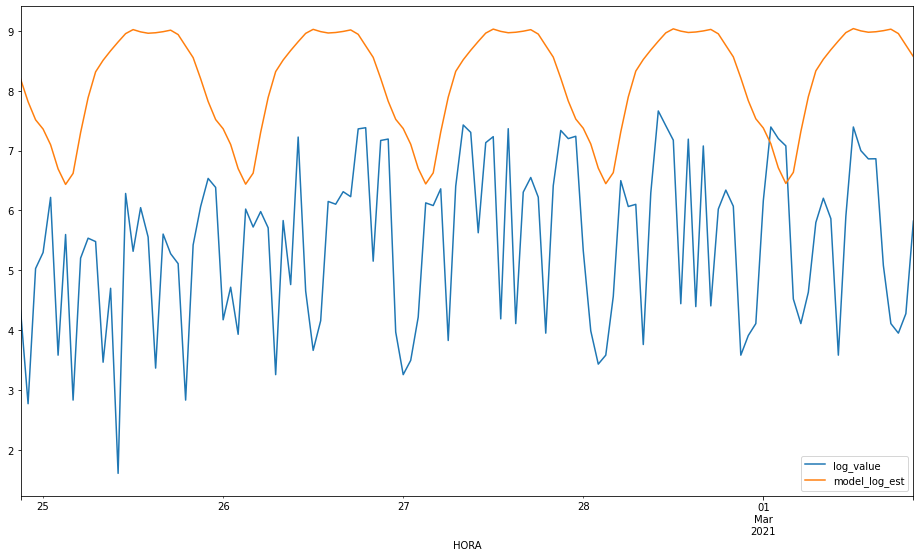

In [240]:
data_test.plot(kind = "line", x = "HORA", y = ['log_value', 'model_log_est'],figsize=(16,9))

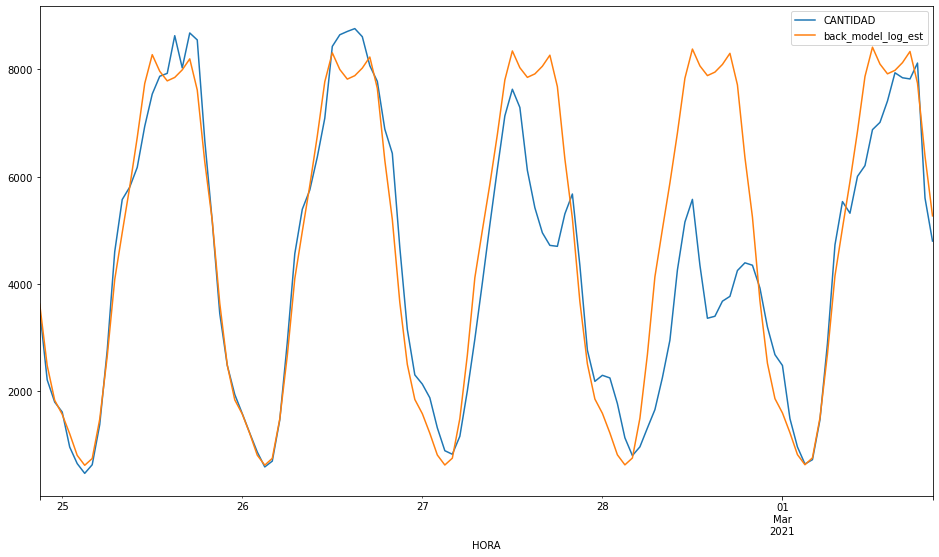

In [241]:
data_test.plot(kind = "line", x = "HORA", y = ['CANTIDAD', 'back_model_log_est'], figsize=(16,9));

In [242]:
data_Results.loc[1, "Model"] = "Log + Estacionalidad"
data_Results.loc[1, "RMSE"] = RMSE(data_test.back_model_log_est, data_test.CANTIDAD)
data_Results

,Model,RMSE
0,Log,2618.5
1,Log + Estacionalidad,1389.52
